* `ReLU` is non linear activation

##02. Neural Network Classification

### 1. Make classification data and get it ready

In [ ]:
import sklearn

In [ ]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [ ]:
len(X), len(y)

(1000, 1000)

In [ ]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"Fitst 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
Fitst 5 samples of y:
 [1 1 1 1 0]


In [ ]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:,1],
                        "label": y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


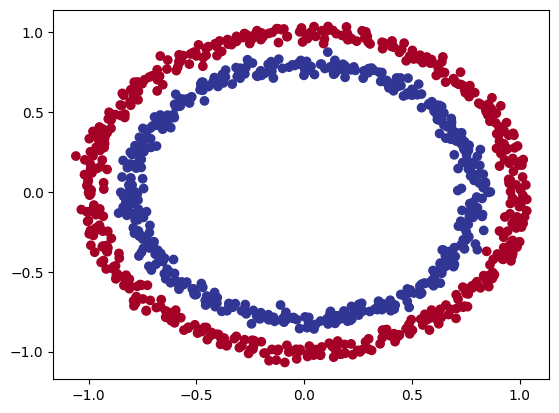

In [ ]:
# Visualize graphically
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

Note: The data we're working with is often called toy dataset

#### 1.1 Check input and output shapes

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

#### 1.2 Turn data into tensors and create train and test splits

In [ ]:
import torch
torch.__version__

'2.0.0+cu118'

In [ ]:
type(X)

numpy.ndarray

In [ ]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [ ]:
X.dtype, y.dtype

(torch.float32, torch.float32)

In [ ]:
# Split data into training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

### 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device
2. Construct a model (by subclassing `nn.module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [ ]:
# import PyTorch and nn
import torch
from torch import nn

# Make device agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
!nvidia-smi

Sun Apr  9 13:33:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Now we've setup device, let's create a model

1. Subclasses `nn.Module`
2. Create 2 `nn.Linear()` layers
3. Defines a `forward()` method
4. Instantiate an instance of our model class and send it to the target `device`

In [ ]:
from sklearn import datasets

In [ ]:
# 1. Construct a model
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear() i.e., 1 hidden layer
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # 5 is just a random number, experience based
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # 1 is the output shape

  # 3. Define a forward method
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
device

'cuda'

In [ ]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [ ]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict() # every value is for single x only

OrderedDict([('0.weight',
              tensor([[ 0.0859, -0.1649],
                      [-0.1746,  0.0199],
                      [-0.3945,  0.4576],
                      [ 0.1735,  0.5197],
                      [-0.6986,  0.3629]], device='cuda:0')),
             ('0.bias',
              tensor([-0.5089, -0.4805,  0.1813, -0.0218,  0.6542], device='cuda:0')),
             ('1.weight',
              tensor([[-0.3394,  0.1851, -0.2084, -0.0881,  0.0917]], device='cuda:0')),
             ('1.bias', tensor([0.4416], device='cuda:0'))])

In [ ]:
# Make some predictions with the model
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of Prediction: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions: \n{untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n {y_test[:10]}")

Length of Prediction: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions: 
tensor([[0.5386],
        [0.5023],
        [0.6059],
        [0.5196],
        [0.5618],
        [0.5400],
        [0.4728],
        [0.4815],
        [0.6076],
        [0.4994]], device='cuda:0')

First 10 labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


#### 2.1 Setup loss function and optimizer

* For regression we might use MAE or MSE (Mean Absolute Error or Mean Squared Error)
* For classification we might use `Binary Cross Entropy` or `Categorical Cross Entropy` (Cross Entropy)

* For optimizer, we can use `SDG` or `Adam`

* For loss function we are using `torch.nn.BECWithLogisticLoss()`


In [ ]:
# Setup loss fnction
# loss_fn = nn.BCELoss # nn.BCELoss = require the input to go through sigmoid function
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [ ]:
# Claculation of accuracy, what percentage does our model get right
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

### 3. Train Model

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward
5. Optimizer step

#### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

OUr model outputs are going to be raw **logits**, so we need to convert it to **probabilties** by passing them to some activation function.

Then we will convert it to prediction labels by rounding them off.

In [ ]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.5386],
        [0.5023],
        [0.6059],
        [0.5196],
        [0.5618]], device='cuda:0', grad_fn=<SliceBackward0>)

In [ ]:
# Use the sigmoid activation function to get value in required range
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6315],
        [0.6230],
        [0.6470],
        [0.6271],
        [0.6369]], device='cuda:0', grad_fn=<SigmoidBackward0>)

We need to set boundaries for rounding off
* y_pred_probs >= 0.5, y=1
* y_pred_probs <0.5, y=0

In [ ]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimensions
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

#### 3.2 Building a training and test loop

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build the training and evaluation loop
for epoch in range(epochs):
  ## Trainig
  model_0.train()

  # 1. Forward Pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # to get output in required range

  # 2. Calculate loss/accuracy
  loss = loss_fn(y_logits, # as BCEWithLogitsLoss required logits as input
                 y_train)

  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3.Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ## Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward Pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    # Print the values
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss: .5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss:  0.73121, Acc: 50.00% | Test loss: 0.72482, Test acc: 50.00%
Epoch: 10 | Loss:  0.70688, Acc: 50.00% | Test loss: 0.70290, Test acc: 50.00%
Epoch: 20 | Loss:  0.69863, Acc: 50.00% | Test loss: 0.69566, Test acc: 50.00%
Epoch: 30 | Loss:  0.69577, Acc: 50.00% | Test loss: 0.69331, Test acc: 50.00%
Epoch: 40 | Loss:  0.69470, Acc: 54.12% | Test loss: 0.69258, Test acc: 60.00%
Epoch: 50 | Loss:  0.69422, Acc: 52.12% | Test loss: 0.69238, Test acc: 54.50%
Epoch: 60 | Loss:  0.69396, Acc: 51.88% | Test loss: 0.69236, Test acc: 51.00%
Epoch: 70 | Loss:  0.69379, Acc: 51.38% | Test loss: 0.69240, Test acc: 50.00%
Epoch: 80 | Loss:  0.69366, Acc: 51.62% | Test loss: 0.69247, Test acc: 49.00%
Epoch: 90 | Loss:  0.69355, Acc: 51.50% | Test loss: 0.69255, Test acc: 49.50%


### 4. Make predictions and evaluate the model

From the matrices it look like our model isn't learning

To visulalise we are going to import `plot_descision_boundary()`

In [ ]:
import requests
from pathlib import Path

# Download helper function from learn PyTorch repo (if it's not already exist)
if Path("helper_function.py").is_file():
  print("helper_functions.py already exists,skipping download")
else:
  print("Downlaod helper_function.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_function.py", "wb") as f:
    f.write(request.content)

from helper_function import plot_predictions, plot_decision_boundary

Downlaod helper_function.py


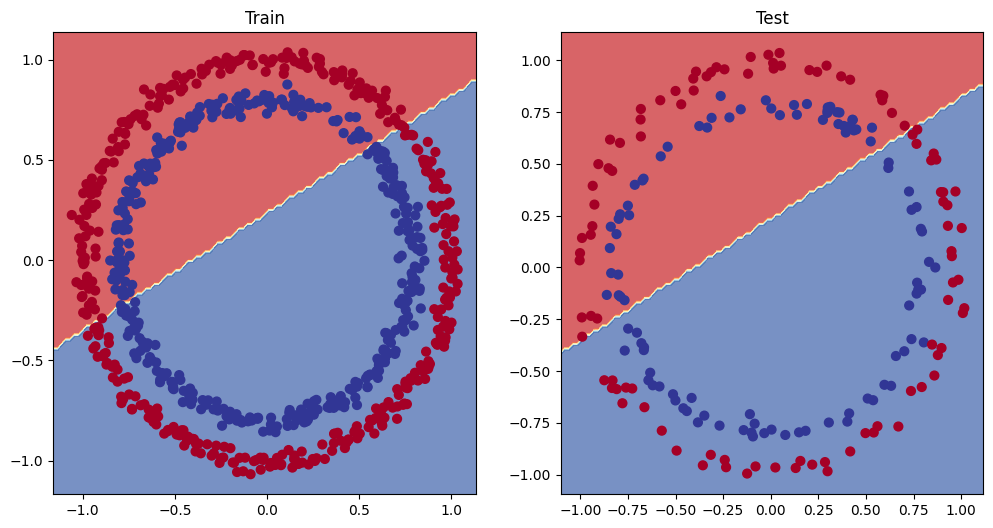

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

### 5. Improving our model

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation function
* Change the learning rate
* Change the loss function

These options are all from model prespective as they dea directly with model.

These are called **hyperparameters**.

In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    #Adding more hidden units
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  # Forward method
  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    # return z
    return self.layer_3(self.layer_2(self.layer_1(x))) # It speed ups the process

model_1 = CircleModelV1().to(device)
model_1, model_1.state_dict()

(CircleModelV1(
   (layer_1): Linear(in_features=2, out_features=10, bias=True)
   (layer_2): Linear(in_features=10, out_features=10, bias=True)
   (layer_3): Linear(in_features=10, out_features=1, bias=True)
 ),
 OrderedDict([('layer_1.weight',
               tensor([[ 0.5406,  0.5869],
                       [-0.1657,  0.6496],
                       [-0.1549,  0.1427],
                       [-0.3443,  0.4153],
                       [ 0.6233, -0.5188],
                       [ 0.6146,  0.1323],
                       [ 0.5224,  0.0958],
                       [ 0.3410, -0.0998],
                       [ 0.5451,  0.1045],
                       [-0.3301,  0.1802]], device='cuda:0')),
              ('layer_1.bias',
               tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                        0.0667, -0.6984], device='cuda:0')),
              ('layer_2.weight',
               tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.049

In [ ]:
# model_1 = nn.Sequential(
#     nn.Linear(in_features=2, out_features=10),
#     nn.Linear(in_features=10, out_features=10),
#     nn.Linear(in_features=10, out_features=1)
# ).to(device)

In [ ]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [ ]:
# Write a training and evaluataion loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 10000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ## Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Claculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss Backward (backpropagation)
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ## Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate loss
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  # Print
  if epoch%100==0:
    print(f"Epch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")

Epch: 0 | Loss: 0.69396, Acc: 50.88 | Test loss: 0.69261, Test acc: 51.00
Epch: 100 | Loss: 0.69305, Acc: 50.38 | Test loss: 0.69379, Test acc: 48.00
Epch: 200 | Loss: 0.69299, Acc: 51.12 | Test loss: 0.69437, Test acc: 46.00
Epch: 300 | Loss: 0.69298, Acc: 51.62 | Test loss: 0.69458, Test acc: 45.00
Epch: 400 | Loss: 0.69298, Acc: 51.12 | Test loss: 0.69465, Test acc: 46.00
Epch: 500 | Loss: 0.69298, Acc: 51.00 | Test loss: 0.69467, Test acc: 46.00
Epch: 600 | Loss: 0.69298, Acc: 51.00 | Test loss: 0.69468, Test acc: 46.00
Epch: 700 | Loss: 0.69298, Acc: 51.00 | Test loss: 0.69468, Test acc: 46.00
Epch: 800 | Loss: 0.69298, Acc: 51.00 | Test loss: 0.69468, Test acc: 46.00
Epch: 900 | Loss: 0.69298, Acc: 51.00 | Test loss: 0.69468, Test acc: 46.00
Epch: 1000 | Loss: 0.69298, Acc: 51.00 | Test loss: 0.69468, Test acc: 46.00
Epch: 1100 | Loss: 0.69298, Acc: 51.00 | Test loss: 0.69468, Test acc: 46.00
Epch: 1200 | Loss: 0.69298, Acc: 51.00 | Test loss: 0.69468, Test acc: 46.00
Epch: 1300 

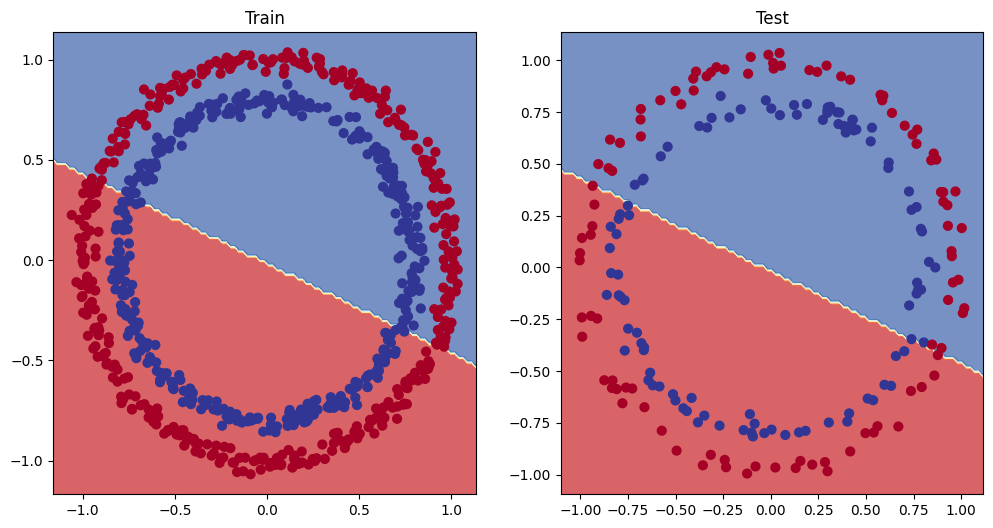

In [ ]:
# Plot the desicion boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 6. Defining non Linear functions


#### 6.1 Recreating non_linear data


In [ ]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    #Adding more hidden units
    self.layer_0 = nn.Linear(in_features=2, out_features=10)
    self.layer_1 = nn.ReLU() # relu is a non linear activation function
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.ReLU()
    self.layer_4 = nn.Linear(in_features=10, out_features=1)

  # Forward method
  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    # return z
    return self.layer_4(self.layer_3(self.layer_2(self.layer_1(self.layer_0(x))))) # It speed ups the process

model_3 = CircleModelV2().to(device)
model_3, model_3.state_dict()

(CircleModelV2(
   (layer_0): Linear(in_features=2, out_features=10, bias=True)
   (layer_1): ReLU()
   (layer_2): Linear(in_features=10, out_features=10, bias=True)
   (layer_3): ReLU()
   (layer_4): Linear(in_features=10, out_features=1, bias=True)
 ),
 OrderedDict([('layer_0.weight',
               tensor([[ 0.5406,  0.5869],
                       [-0.1657,  0.6496],
                       [-0.1549,  0.1427],
                       [-0.3443,  0.4153],
                       [ 0.6233, -0.5188],
                       [ 0.6146,  0.1323],
                       [ 0.5224,  0.0958],
                       [ 0.3410, -0.0998],
                       [ 0.5451,  0.1045],
                       [-0.3301,  0.1802]], device='cuda:0')),
              ('layer_0.bias',
               tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                        0.0667, -0.6984], device='cuda:0')),
              ('layer_2.weight',
               tensor([[ 0.2856, -0.2686, 

In [ ]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

In [ ]:
# Write a training and evaluataion loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 5000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ## Training
  model_3.train()

  # 1. Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Claculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss Backward (backpropagation)
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ## Testing
  model_3.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate loss
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  # Print
  if epoch%100==0:
    print(f"Epch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")

Epch: 0 | Loss: 0.69295, Acc: 50.00 | Test loss: 0.69319, Test acc: 50.00
Epch: 100 | Loss: 0.69115, Acc: 52.88 | Test loss: 0.69102, Test acc: 52.50
Epch: 200 | Loss: 0.68977, Acc: 53.37 | Test loss: 0.68940, Test acc: 55.00
Epch: 300 | Loss: 0.68795, Acc: 53.00 | Test loss: 0.68723, Test acc: 56.00
Epch: 400 | Loss: 0.68517, Acc: 52.75 | Test loss: 0.68411, Test acc: 56.50
Epch: 500 | Loss: 0.68102, Acc: 52.75 | Test loss: 0.67941, Test acc: 56.50
Epch: 600 | Loss: 0.67515, Acc: 54.50 | Test loss: 0.67285, Test acc: 56.00
Epch: 700 | Loss: 0.66659, Acc: 58.38 | Test loss: 0.66322, Test acc: 59.00
Epch: 800 | Loss: 0.65160, Acc: 64.00 | Test loss: 0.64757, Test acc: 67.50
Epch: 900 | Loss: 0.62362, Acc: 74.00 | Test loss: 0.62145, Test acc: 79.00
Epch: 1000 | Loss: 0.56818, Acc: 87.75 | Test loss: 0.57378, Test acc: 86.50
Epch: 1100 | Loss: 0.48153, Acc: 93.50 | Test loss: 0.49935, Test acc: 90.50
Epch: 1200 | Loss: 0.37056, Acc: 97.75 | Test loss: 0.40595, Test acc: 92.00
Epch: 1300 

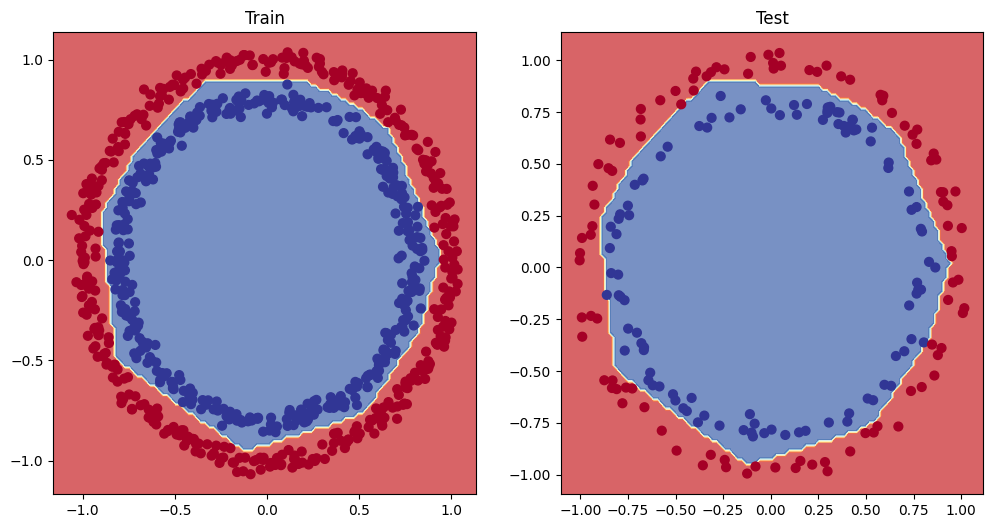

In [ ]:
# Plot the desicion boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

### 7. Replicating non linear activation functions
NN is big stack of linear and non linear function

In [ ]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

In [ ]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

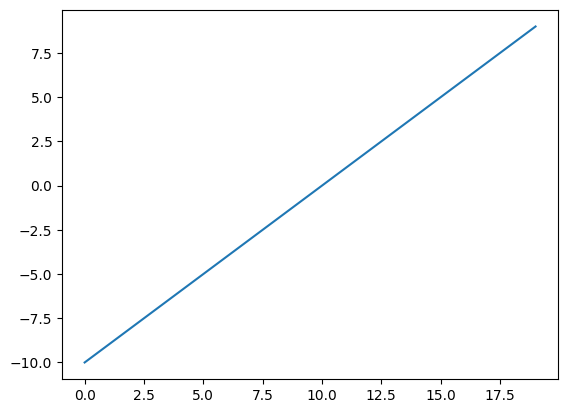

In [ ]:
# Visulaize the data
plt.plot(A)

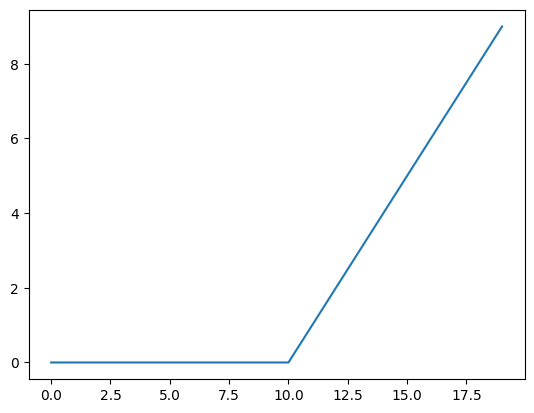

In [ ]:
plt.plot(torch.relu(A));

In [ ]:
def relu(x: torch.Tensor) -> torch.Tensor: # this shows that the output must be a tensor
  return torch.maximum(torch.tensor(0), x) # input must be tensros

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

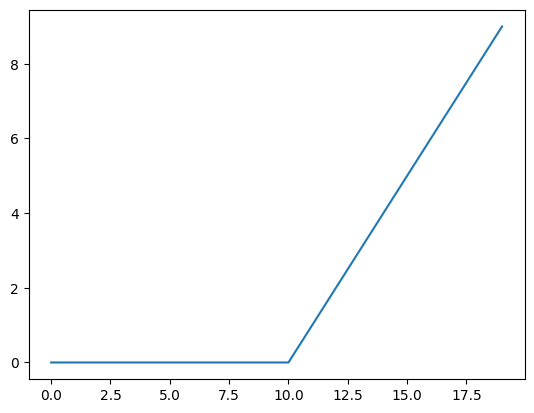

In [ ]:
# Plot ReLU activation function
plt.plot(relu(A))

In [ ]:
# Let's do the same for sigmoid
def sigmoid(x):
  return 1/(1+torch.exp(-x))
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

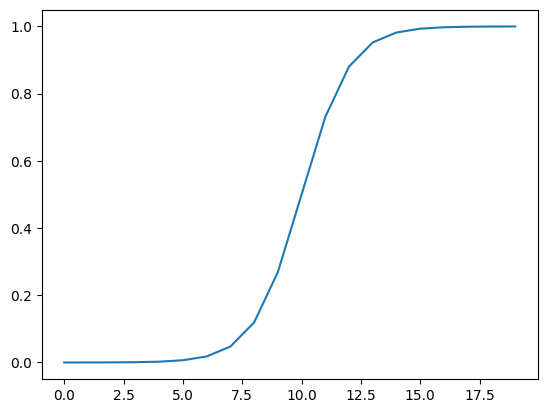

In [ ]:
plt.plot(sigmoid(A))

### 8. Putting it all together with a multi class classification problem

* Binary classification
* Multi-class classification

#### 8.1 Creating a toy multi-class dataset

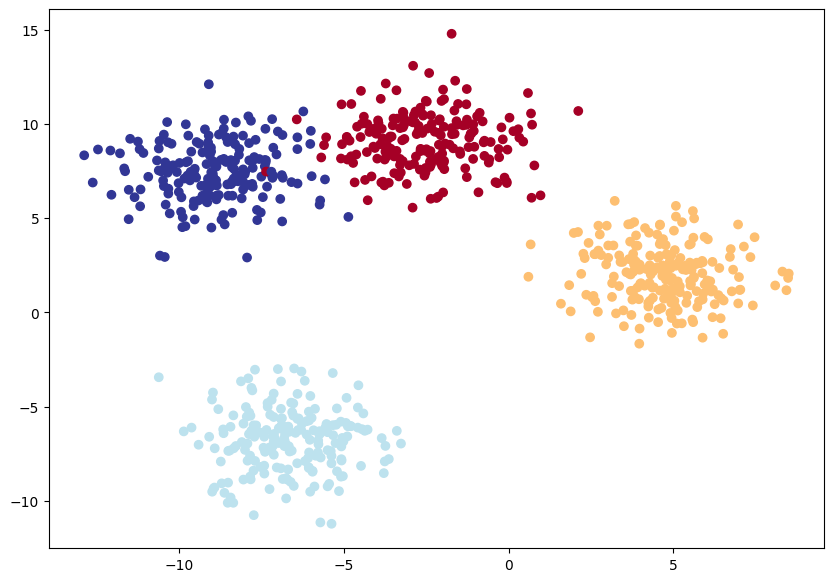

In [ ]:
# Importing requirements
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs # a function used to make to make data
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creations
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                           n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob, X_blob_test, y_blob, y_blob_test = train_test_split(X_blob,
                                                            y_blob,
                                                            test_size=0.2,
                                                            random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

#### 8.2 Building a multiclass classification

In [ ]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Build a multiclass classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initializes multiclass classification.

    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of output features (number of output classes)
      hidden_units (int): Number of hidden units between layers
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=2,
                      output_features=4,
                      hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
X_blob.shape, y_blob.shape

(torch.Size([800, 2]), torch.Size([800]))

#### 8.3 Create a loss function (criterion or cost function) and optimizer for multi-class classification

In [ ]:
# Create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

#### 8.4 Getting predictions without training
Logits -> Pred probs (use `torch.softmax`) -> Pred labels (take the argmax)

In [ ]:
model_4.eval() # this is important as donno why next code box will not run without this
with torch.inference_mode():
  y_logits = model_4(X_blob.to(device))
y_logits

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        ...,
        [-0.0148, -1.5722, -0.2221,  0.9874],
        [ 2.3231,  0.6656,  2.6783,  1.1564],
        [ 2.1249, -0.9140,  2.2318,  2.1890]], device='cuda:0')

In [ ]:
# COnverting logits to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:5]

tensor([[0.1838, 0.3422, 0.1500, 0.3239],
        [0.2199, 0.0377, 0.1839, 0.5586],
        [0.3406, 0.0482, 0.5326, 0.0785],
        [0.3405, 0.0657, 0.4446, 0.1492],
        [0.2527, 0.0424, 0.2283, 0.4766]], device='cuda:0')

In [ ]:
# Transferring data to device
X_blob, y_blob, X_blob_test, y_blob_test = X_blob.to(device), y_blob.to(device), X_blob_test.to(device), y_blob_test.to(device)

In [ ]:
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0')

In [ ]:
torch.max(y_pred_probs[0])

tensor(0.3422, device='cuda:0')

#### 8.5 Create a training and testing loop

In [ ]:
# Fit the mult-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Number of epochs
epochs = 1000

# LOOP through data
for epoch in range(epochs):
  ## Trainig
  model_4.train()

  # Forward
  y_logits = model_4(X_blob)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # loss
  loss = loss_fn(y_logits, y_blob)
  acc = accuracy_fn(y_true=y_blob,
                    y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_pred)

    # Print out stuffs
    if epoch%10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}%, Test loss: {test_loss:.4f}. Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 1.0432, Acc: 65.50%, Test loss: 0.5786. Test acc: 23.00
Epoch: 10 | Loss: 0.1440, Acc: 99.12%, Test loss: 0.1304. Test acc: 23.00
Epoch: 20 | Loss: 0.0806, Acc: 99.12%, Test loss: 0.0722. Test acc: 23.00
Epoch: 30 | Loss: 0.0592, Acc: 99.12%, Test loss: 0.0513. Test acc: 23.00
Epoch: 40 | Loss: 0.0489, Acc: 99.00%, Test loss: 0.0410. Test acc: 23.00
Epoch: 50 | Loss: 0.0429, Acc: 99.00%, Test loss: 0.0349. Test acc: 23.00
Epoch: 60 | Loss: 0.0391, Acc: 99.00%, Test loss: 0.0308. Test acc: 23.00
Epoch: 70 | Loss: 0.0364, Acc: 99.00%, Test loss: 0.0280. Test acc: 23.00
Epoch: 80 | Loss: 0.0345, Acc: 99.00%, Test loss: 0.0259. Test acc: 23.00
Epoch: 90 | Loss: 0.0330, Acc: 99.12%, Test loss: 0.0242. Test acc: 23.00
Epoch: 100 | Loss: 0.0318, Acc: 99.12%, Test loss: 0.0229. Test acc: 23.00
Epoch: 110 | Loss: 0.0309, Acc: 99.12%, Test loss: 0.0219. Test acc: 23.00
Epoch: 120 | Loss: 0.0302, Acc: 99.12%, Test loss: 0.0210. Test acc: 23.00
Epoch: 130 | Loss: 0.0295, Acc: 99.1

In [ ]:
#### 8.6 Making and evaluating prediction with PyTorch multi-class modekl

In [ ]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  6.1117,  18.9106, -22.9632, -14.6995],
        [  9.5662, -23.8503,   5.8412,  17.7025],
        [ -8.4025, -21.8530,  30.5466,  17.0857],
        [  2.1340,  14.6655, -13.7829, -11.2652],
        [ 13.2141,   3.9343, -21.4953,  -3.6479],
        [ 10.8391, -29.6208,   8.5481,  22.0345],
        [ -9.3843, -15.7081,  27.1174,  12.4538],
        [ 11.9275,  -3.3287, -13.8623,   1.9499],
        [ -7.8685, -31.8187,  37.6564,  24.6508],
        [ 12.1832,  -0.6223, -16.3792,  -0.1247]], device='cuda:0')

In [ ]:
# Go from logits -> Prediction probabilities
y_preds_probs = torch.softmax(y_logits, dim=1)
y_pred_probs

tensor([[0.1838, 0.3422, 0.1500, 0.3239],
        [0.2199, 0.0377, 0.1839, 0.5586],
        [0.3406, 0.0482, 0.5326, 0.0785],
        ...,
        [0.2106, 0.0444, 0.1712, 0.5738],
        [0.3415, 0.0651, 0.4871, 0.1063],
        [0.3099, 0.0148, 0.3449, 0.3304]], device='cuda:0')

In [ ]:
# Final data output
y_pred = y_preds_probs.argmax(dim=1)
y_pred

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 0, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

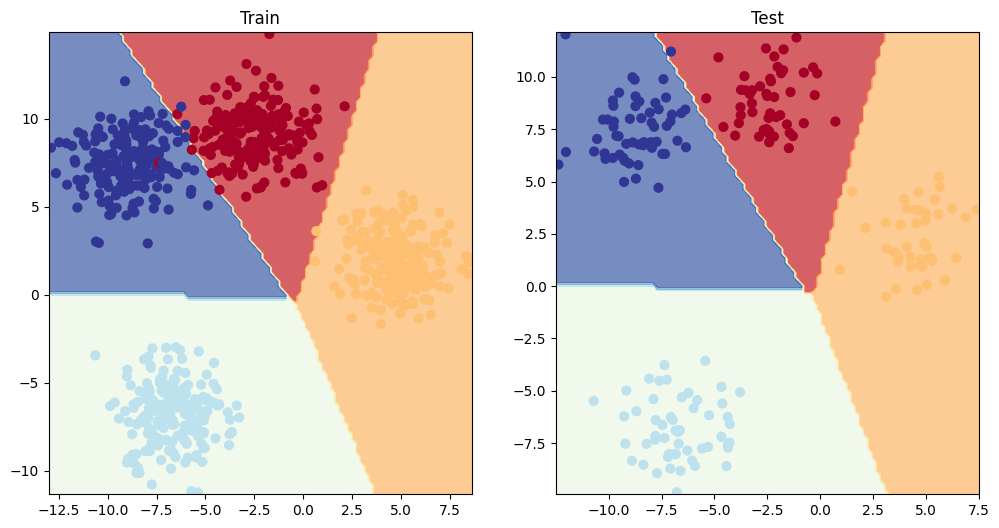

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4,  X_blob, y_blob)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

### 9. A few more classification metrics... (to evaluate our classification model)

* Accuracy - out of 100 samples, how many does our model get right?
* Precision
* Recall
* F1-score
* Confusion matirx
* Classification report